In [1675]:
import torch
from torch import nn
from torch import optim
from torch import functional as F
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as npb

## Create the dataset

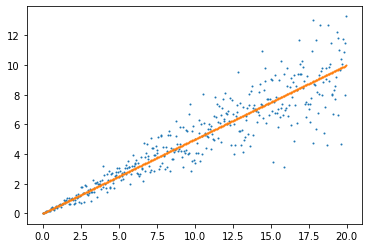

In [1790]:
def create_dataset():
    x = np.arange(0, 20, 0.05)
    y = x * 0.5
    y_noise = y + np.random.normal(0, 0.5, (len(x))) * x/5
    return x, y, y_noise

x, y, y_noise = create_dataset()

plt.scatter(x, y_noise, s=1)
plt.scatter(x, y, s=1)
plt.show()


In [1791]:
def t(x):
    return torch.from_numpy(x).float()[..., None]

split_idx = int(len(x)*0.7)
x_train = t(x[..., :split_idx])
x_test = t(x[..., split_idx:])
y_true_train = t(y[..., :split_idx])
y_true_test = t(y[..., split_idx:])
y_train = t(y_noise[..., :split_idx])
y_test = t(y_noise[..., split_idx:])

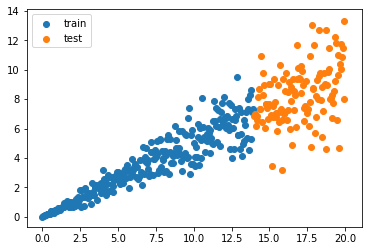

In [1792]:
plt.scatter(x_train, y_train, label="train")
plt.scatter(x_test, y_test, label="test")
plt.legend()

plt.show()

In [1793]:
def train_model(model, loss_fn, optimizer, iterations=100, print_every=50, lr=0.001):
    optimizer.lr = lr

    for i in range(iterations):
        model.train()
        out = model(x_train)
        loss = loss_fn(y_train, out)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % print_every == 0:
            with torch.no_grad():
                model.eval()
                out = model(x_test)
                test_loss = loss_fn(y_test, out)
                print(loss, test_loss)

In [1794]:
def visualize_model(model):
    model.eval()
    plt.scatter(x_train, y_train)
    out = model(x_train).detach().numpy().squeeze()
    plt.scatter(x_train, y_true_train, s=1)
    plt.scatter(x_train, out, s=1)

    plt.scatter(x_test, y_test)
    out = model(x_test).detach().numpy().squeeze()
    plt.scatter(x_test, y_true_test, s=1)
    plt.scatter(x_test, out, s=1)

## Model with MSE loss

In [1795]:
mse_model = nn.Sequential(
    nn.Linear(1, 20),
    nn.LeakyReLU(0.3),
    nn.Linear(20, 1),
)
mse_loss = nn.MSELoss()
adam = optim.Adam(params=mse_model.parameters(), lr=0.001)

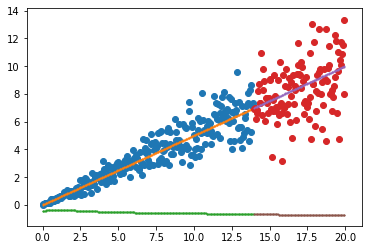

In [1796]:
# just before training
visualize_model(mse_model)

tensor(6161.7705, grad_fn=<SumBackward0>) tensor(83.7457)
tensor(186.2337, grad_fn=<SumBackward0>) tensor(3.4067)
tensor(185.8999, grad_fn=<SumBackward0>) tensor(3.3827)
tensor(185.4740, grad_fn=<SumBackward0>) tensor(3.3647)


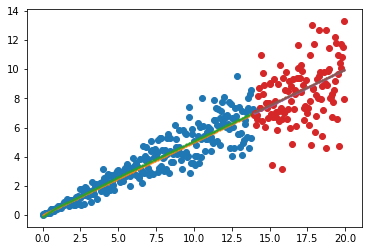

In [1797]:
train_model(mse_model, mse_loss, adam, iterations=4000, print_every=1000)

# after training
visualize_model(mse_model)

## Probabilistic model with NLL loss

In [1815]:
class UncertaintyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = nn.Sequential(
            nn.BatchNorm1d(1), # trick to normalize the input automatically
            nn.Linear(1, 3),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(3),
            nn.Linear(3, 2),
        )
        nn.init.kaiming_normal_(self.backbone[1].weight.data)
        nn.init.ones_(self.backbone[1].bias.data)
        nn.init.kaiming_normal_(self.backbone[4].weight.data)
        nn.init.ones_(self.backbone[4].bias.data)
    
    def forward(self, X):
        out = self.backbone(X)
        mean = out[..., 0][..., None]
        # ensure we always obtain a possitive value for the std
        std = torch.clamp(out[..., 1][..., None], min=0.01)
        
        norm_dist = torch.distributions.Normal(mean, std)
        return norm_dist

def nll_loss(observations, dists):
    return -dists.log_prob(observations).sum()

model = UncertaintyModel()
adam = optim.Adam(params=model.parameters(), lr=0.001)

In [1818]:
train_model(model, nll_loss, adam, iterations=8000, print_every=800, lr=0.001)

tensor(669.4555, grad_fn=<NegBackward>) tensor(460.9718)
tensor(644.4432, grad_fn=<NegBackward>) tensor(438.6206)
tensor(618.6597, grad_fn=<NegBackward>) tensor(417.3480)
tensor(588.7144, grad_fn=<NegBackward>) tensor(396.4015)
tensor(553.1030, grad_fn=<NegBackward>) tensor(375.0503)
tensor(537.9935, grad_fn=<NegBackward>) tensor(341.4619)
tensor(351.8403, grad_fn=<NegBackward>) tensor(296.1947)
tensor(217.7378, grad_fn=<NegBackward>) tensor(241.1712)
tensor(217.8949, grad_fn=<NegBackward>) tensor(240.5221)
tensor(217.7087, grad_fn=<NegBackward>) tensor(242.6575)


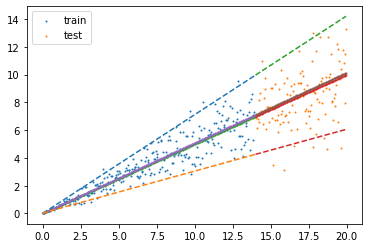

In [1819]:
# do not forget to use eval mode as we are using batch norm layers
model.eval()

plt.scatter(x_train, y_train, s=1, label="train")
plt.scatter(x_test, y_test, s=1, label="test")
plt.scatter(x_train, y_true_train, s=1)
plt.scatter(x_test, y_true_test, s=1)

train_dist = model(x_train)
train_mean = train_dist.mean.detach().numpy().squeeze()
train_std = train_dist.stddev.detach().numpy().squeeze()

plt.scatter(x_train, train_mean, s=1)
plt.plot(x_train.numpy(), train_mean+2*train_std, linestyle="--")
plt.plot(x_train.numpy(), train_mean-2*train_std, linestyle="--")

test_dist = model(x_test)
test_mean = test_dist.mean.detach().numpy().squeeze()
test_std = test_dist.stddev.detach().numpy().squeeze()

plt.scatter(x_test, test_mean, s=1)
plt.plot(x_test.numpy(), test_mean+2*test_std, linestyle="--")
plt.plot(x_test.numpy(), test_mean-2*test_std, linestyle="--")

plt.legend()